## Chest X-Ray (Pneumonia): Transfer Learning 

Using Transfer Learning with VGG19

In [3]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to avoid warning messages

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from tensorflow.random import set_seed
set_seed(421)

import warnings
warnings.filterwarnings('ignore')

In [4]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [5]:
# folder structure 
#Notebook
#    !------ chest_xray_data
#                  !-------------train
#                  !-------------test
#                  !-------------validation
#
main_path = "./chest_xray_data/"

train_path = os.path.join(main_path,"TRAIN")
test_path = os.path.join(main_path,"TEST")
val_path  = os.path.join(main_path,"VALIDATION")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

val_normal = glob.glob(val_path+"/NORMAL/*.jpeg")
val_pneumonia = glob.glob(val_path+"/PNEUMONIA/*.jpeg")

In [6]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), 
                        columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), 
                       columns = ['class'])
df_test['image'] = [x for x in test_list]

val_list = [x for x in val_normal]
val_list.extend([x for x in val_pneumonia])

df_val = pd.DataFrame(np.concatenate([['Normal']*len(val_normal) , ['Pneumonia']*len(val_pneumonia)]), 
                      columns = ['class'])
df_val['image'] = [x for x in val_list]

train_df = df_train
test_df = df_test
val_df = df_val

### Data Preparation is performed in the same way as in previous notebooks

In [8]:
# see: https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
print ('shapes. Train: ',train_df.shape, 'val : ', val_df.shape, 'test : ',df_test.shape)
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(test_df,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

shapes. Train:  (4099, 2) val :  (879, 2) test :  (878, 2)
Found 4099 validated image filenames belonging to 2 classes.
Found 879 validated image filenames belonging to 2 classes.
Found 878 validated image filenames belonging to 2 classes.


In [10]:
# to improve class balancing we calculate the weights to add to the training process

COUNT_NORMAL = len(train_normal)+len(test_normal)+len(val_normal)
COUNT_PNEUMONIA = len(train_pneumonia)+len(test_pneumonia)+len(val_pneumonia)

initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

calculated_class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 0.99299
Weight for class 0: 1.85
Weight for class 1: 0.69


## Transfer Learning (adding some layers to previously trained network)

Consists of using a pretrained model as a feature extractor. In this notebook, the selected model is the VGG19 available on the Keras Package 

We include a few layers after removing the 'head'. We only train these new layers.The weights of the original VGG19 network remain the same.

In [11]:
#Setting callbakcs

initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0000001,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 10,                                   
    min_delt = 0.0000001,                                
    cooldown = 0,                               
    verbose = 1
) 

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

In [12]:
from keras.applications.vgg19 import VGG19

base_model = VGG19(    
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False

def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [13]:
keras.backend.clear_session()

model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=lr_schedule), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [14]:
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          class_weight = calculated_class_weight,
          validation_data=ds_val,
          callbacks=[early_stopping_cb,checkpoint_cb]);

Epoch 1/50
129/129 [==============================] - 938s 7s/step - loss: 0.4413 - binary_accuracy: 0.8119 - val_loss: 0.3690 - val_binary_accuracy: 0.8407
Epoch 2/50
129/129 [==============================] - 911s 7s/step - loss: 0.3155 - binary_accuracy: 0.8663 - val_loss: 0.2814 - val_binary_accuracy: 0.8874
Epoch 3/50
129/129 [==============================] - 911s 7s/step - loss: 0.2803 - binary_accuracy: 0.8873 - val_loss: 0.2232 - val_binary_accuracy: 0.9204
Epoch 4/50
129/129 [==============================] - 914s 7s/step - loss: 0.2428 - binary_accuracy: 0.9036 - val_loss: 0.2508 - val_binary_accuracy: 0.8987
Epoch 5/50
129/129 [==============================] - 913s 7s/step - loss: 0.2429 - binary_accuracy: 0.9044 - val_loss: 0.4268 - val_binary_accuracy: 0.8180
Epoch 6/50
129/129 [==============================] - 913s 7s/step - loss: 0.2395 - binary_accuracy: 0.9036 - val_loss: 0.3011 - val_binary_accuracy: 0.8942
Epoch 7/50
129/129 [==============================] - 913s

#### Measuring CNN Accuracy

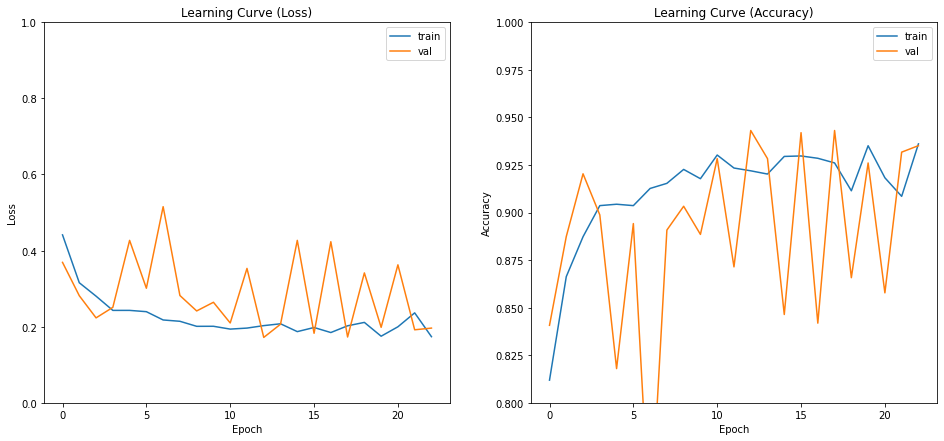

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,7))
sns.lineplot(x = history.epoch, y = history.history['loss'], ax=ax1)
sns.lineplot(x = history.epoch, y = history.history['val_loss'], ax=ax1)
ax1.set_title('Learning Curve (Loss)')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylim(0, 1)
ax1.legend(['train', 'val'], loc='best')
#
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'], ax=ax2)
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'], ax=ax2)
ax2.set_title('Learning Curve (Accuracy)')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylim(0.80, 1.0)
ax2.legend(['train', 'val'], loc='best')
plt.show()

In [17]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.1718212515115738
Val accuracy: 0.9431172013282776


In [18]:
score = model_pretrained.evaluate(ds_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14505967497825623
Test accuracy: 0.9441913366317749


### Result Performance Evaluation</a>  

In [21]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = test_df['class'].copy().map(num_label).astype('int')

In [25]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.9554865424430642


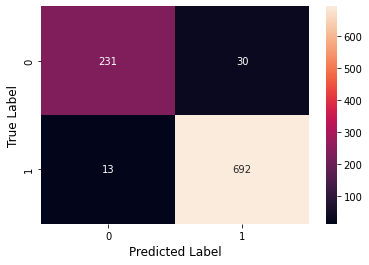

In [26]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [27]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.95      0.89      0.91       261
           1       0.96      0.98      0.97       705

    accuracy                           0.96       966
   macro avg       0.95      0.93      0.94       966
weighted avg       0.96      0.96      0.96       966



ROC_AUC:  0.9858699491861634


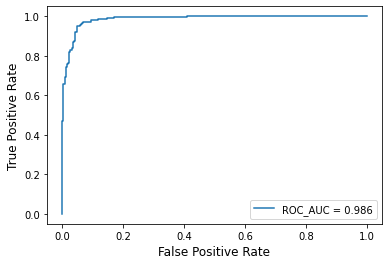

In [28]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

Some improvements in the final result, but the validation accuracy fluctuates, maybe we don't have enough data

In [29]:
#EOF